# EDA - Consumption Data

Data:

Information: This script should prepare the consumption data for later merging.

Deliver: Silver Level Data of Consumption.

In [1]:
# load modules
import pandas as pd
import datetime as dt
import numpy as np

In [2]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

# Load environment variables from .env file
load_dotenv()

# Get database connection parameters from environment variables
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')

# Create the database URL
db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Create an engine
engine = create_engine(db_url)

# Define your query
query = 'SELECT * FROM "01_bronze"."raw_market_consumption"'

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql(query, engine)

# Display the DataFrame
print(df.head())

             start_date             end_date   
0  Jan 1, 2023 12:00 AM  Jan 1, 2023 1:00 AM  \
1   Jan 1, 2023 1:00 AM  Jan 1, 2023 2:00 AM   
2   Jan 1, 2023 2:00 AM  Jan 1, 2023 3:00 AM   
3   Jan 1, 2023 3:00 AM  Jan 1, 2023 4:00 AM   
4   Jan 1, 2023 4:00 AM  Jan 1, 2023 5:00 AM   

  total_(grid_load)_[mwh]_calculated_resolutions   
0                                      38,536.50  \
1                                      37,935.50   
2                                      37,103.25   
3                                      36,139.50   
4                                      35,711.50   

  residual_load_[mwh]_calculated_resolutions   
0                                   6,765.50  \
1                                   5,043.50   
2                                   3,993.75   
3                                   5,666.75   
4                                   5,809.00   

  hydro_pumped_storage_[mwh]_calculated_resolutions  
0                                          1,933.50  
1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83039 entries, 0 to 83038
Data columns (total 5 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   start_date                                         83039 non-null  object
 1   end_date                                           83039 non-null  object
 2   total_(grid_load)_[mwh]_calculated_resolutions     83027 non-null  object
 3   residual_load_[mwh]_calculated_resolutions         83027 non-null  object
 4   hydro_pumped_storage_[mwh]_calculated_resolutions  83028 non-null  object
dtypes: object(5)
memory usage: 3.2+ MB


In [4]:
import pytz

# Convert 'start_date' and 'end_date' to datetime
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

# Localize to the specific time zone (e.g., Europe/Berlin) handling DST transitions
df['start_date'] = df['start_date'].dt.tz_localize('Europe/Berlin', ambiguous='NaT', nonexistent='NaT')
df['end_date'] = df['end_date'].dt.tz_localize('Europe/Berlin', ambiguous='NaT', nonexistent='NaT')

/var/folders/fv/lggv_bnd6995v5g2v3mdb8z40000gn/T/ipykernel_4931/1261700730.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')


In [5]:
df.head()

,start_date,end_date,total_(grid_load)_[mwh]_calculated_resolutions,residual_load_[mwh]_calculated_resolutions,hydro_pumped_storage_[mwh]_calculated_resolutions
0,2023-01-01 00:00:00+01:00,2023-01-01 01:00:00+01:00,"38,536.50","6,765.50","1,933.50"
1,2023-01-01 01:00:00+01:00,2023-01-01 02:00:00+01:00,"37,935.50","5,043.50","2,025.50"
2,2023-01-01 02:00:00+01:00,2023-01-01 03:00:00+01:00,"37,103.25","3,993.75","3,636.75"
3,2023-01-01 03:00:00+01:00,2023-01-01 04:00:00+01:00,"36,139.50","5,666.75","4,385.50"
4,2023-01-01 04:00:00+01:00,2023-01-01 05:00:00+01:00,"35,711.50","5,809.00","4,411.50"


In [6]:
# Generate complete date range with hourly frequency
full_time_range = pd.date_range(start=df['start_date'].min(), end=df['start_date'].max(), freq='H', tz='Europe/Berlin')

# Create a DataFrame with the complete time range
complete_time_df = pd.DataFrame(full_time_range, columns=['start_date'])

# Merge the original DataFrame with the complete time range DataFrame
df_complete = pd.merge(complete_time_df, df, on='start_date', how='left')

# Recalculate 'end_date' for missing values by adding one hour to 'start_date'
df_complete['end_date'] = df_complete.apply(
    lambda row: row['start_date'] + pd.Timedelta(hours=1) if pd.isna(row['end_date']) else row['end_date'],
    axis=1
)

# Drop rows where 'start_date' or 'end_date' is NaT
df_complete.dropna(subset=['start_date', 'end_date'], inplace=True)


In [7]:
df_complete.columns

Index(['start_date', 'end_date',
       'total_(grid_load)_[mwh]_calculated_resolutions',
       'residual_load_[mwh]_calculated_resolutions',
       'hydro_pumped_storage_[mwh]_calculated_resolutions'],
      dtype='object')

In [8]:
# List of columns to be cleaned
numeric_columns = [
    'total_(grid_load)_[mwh]_calculated_resolutions',
       'residual_load_[mwh]_calculated_resolutions',
       'hydro_pumped_storage_[mwh]_calculated_resolutions'
]

# Function to clean numeric columns
def clean_numeric_columns(df, columns):
    for col in columns:
        # Convert all values to string to use .str accessor
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        # Convert to numeric values
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Clean numeric columns
df_complete = clean_numeric_columns(df_complete, numeric_columns)

# Display the cleaned dataframe
print(df_complete.head())

# Identify and display rows where duplicates occur in 'start_date'
duplicates = df_complete[df_complete.duplicated(subset='start_date', keep=False)]

# Display the DataFrame with duplicates
print("\nDataFrame with duplicates in 'start_date':")
print(duplicates)

                 start_date                  end_date   
0 2015-01-01 00:00:00+01:00 2015-01-01 01:00:00+01:00  \
1 2015-01-01 01:00:00+01:00 2015-01-01 02:00:00+01:00   
2 2015-01-01 02:00:00+01:00 2015-01-01 03:00:00+01:00   
3 2015-01-01 03:00:00+01:00 2015-01-01 04:00:00+01:00   
4 2015-01-01 04:00:00+01:00 2015-01-01 05:00:00+01:00   

   total_(grid_load)_[mwh]_calculated_resolutions   
0                                        44600.25  \
1                                        43454.75   
2                                        41963.25   
3                                        40617.75   
4                                        39936.75   

   residual_load_[mwh]_calculated_resolutions   
0                                    35955.75  \
1                                    34641.00   
2                                    32909.25   
3                                    31548.00   
4                                    30773.50   

   hydro_pumped_storage_[mwh]_calculated_re

In [9]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83039 entries, 0 to 83038
Data columns (total 5 columns):
 #   Column                                             Non-Null Count  Dtype                        
---  ------                                             --------------  -----                        
 0   start_date                                         83039 non-null  datetime64[ns, Europe/Berlin]
 1   end_date                                           83039 non-null  datetime64[ns, Europe/Berlin]
 2   total_(grid_load)_[mwh]_calculated_resolutions     83009 non-null  float64                      
 3   residual_load_[mwh]_calculated_resolutions         83009 non-null  float64                      
 4   hydro_pumped_storage_[mwh]_calculated_resolutions  83010 non-null  float64                      
dtypes: datetime64[ns, Europe/Berlin](2), float64(3)
memory usage: 3.2 MB


In [10]:
# Display the missing timestamps
missing_timestamps = df_complete[df_complete['end_date'].isna()]['start_date']
print("Missing timestamps:")
print(missing_timestamps)

# Display the completed DataFrame
print("\nCompleted DataFrame:")
print(df_complete)

Missing timestamps:
Series([], Name: start_date, dtype: datetime64[ns, Europe/Berlin])

Completed DataFrame:
                     start_date                  end_date   
0     2015-01-01 00:00:00+01:00 2015-01-01 01:00:00+01:00  \
1     2015-01-01 01:00:00+01:00 2015-01-01 02:00:00+01:00   
2     2015-01-01 02:00:00+01:00 2015-01-01 03:00:00+01:00   
3     2015-01-01 03:00:00+01:00 2015-01-01 04:00:00+01:00   
4     2015-01-01 04:00:00+01:00 2015-01-01 05:00:00+01:00   
...                         ...                       ...   
83034 2024-06-21 19:00:00+02:00 2024-06-21 08:00:00+02:00   
83035 2024-06-21 20:00:00+02:00 2024-06-21 09:00:00+02:00   
83036 2024-06-21 21:00:00+02:00 2024-06-21 10:00:00+02:00   
83037 2024-06-21 22:00:00+02:00 2024-06-21 11:00:00+02:00   
83038 2024-06-21 23:00:00+02:00 2024-06-22 12:00:00+02:00   

       total_(grid_load)_[mwh]_calculated_resolutions   
0                                            44600.25  \
1                                           

In [11]:
df_complete.columns

Index(['start_date', 'end_date',
       'total_(grid_load)_[mwh]_calculated_resolutions',
       'residual_load_[mwh]_calculated_resolutions',
       'hydro_pumped_storage_[mwh]_calculated_resolutions'],
      dtype='object')

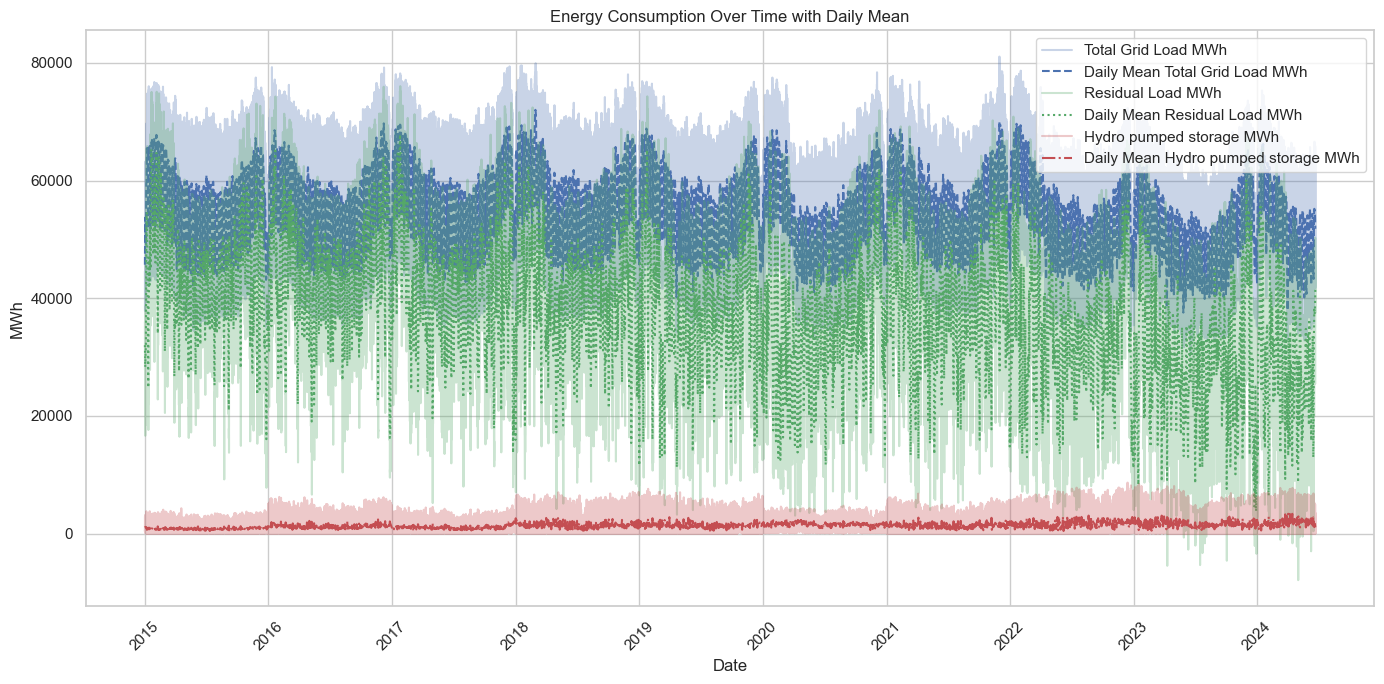

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate a daily mean for plotting
df_daily_mean = df_complete.resample('D', on='start_date').mean().reset_index()

# Setting the seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(14, 7))

# Plotting total_mwh
sns.lineplot(data=df_complete, x='start_date', y='total_(grid_load)_[mwh]_calculated_resolutions', label='Total Grid Load MWh', color='b', alpha=0.3)
sns.lineplot(data=df_daily_mean, x='start_date', y='total_(grid_load)_[mwh]_calculated_resolutions', label='Daily Mean Total Grid Load MWh', color='b', linestyle='--')

# Plotting sum of renewables
sns.lineplot(data=df_complete, x='start_date', y='residual_load_[mwh]_calculated_resolutions', label='Residual Load MWh', color='g', alpha=0.3)
sns.lineplot(data=df_daily_mean, x='start_date', y='residual_load_[mwh]_calculated_resolutions', label='Daily Mean Residual Load MWh', color='g', linestyle=':')

# Plotting sum of conventional energy
sns.lineplot(data=df_complete, x='start_date', y='hydro_pumped_storage_[mwh]_calculated_resolutions', label='Hydro pumped storage MWh', color='r', alpha=0.3)
sns.lineplot(data=df_daily_mean, x='start_date', y='hydro_pumped_storage_[mwh]_calculated_resolutions', label='Daily Mean Hydro pumped storage MWh', color='r', linestyle='-.')


# Enhancing the plot
plt.title('Energy Consumption Over Time with Daily Mean')
plt.xlabel('Date')
plt.ylabel('MWh')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
